In [1]:
# Mengimpor library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [2]:
import cv2 
import os
import re

# -------------------- Utility function ------------------------
def normalize_label(str_):
    str_ = str_.replace(" ", "")
    str_ = str_.translate(str_.maketrans("","", "()"))
    str_ = str_.split("_")
    return ''.join(str_[:2])

def normalize_desc(folder, sub_folder):
    text = folder + " - " + sub_folder 
    text = re.sub(r'\d+', '', text)
    text = text.replace(".", "")
    text = text.strip()
    return text

def print_progress(val, val_len, folder, sub_folder, filename, bar_size=10):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] folder : %s/%s/ ----> file : %s" % (progr, folder, sub_folder, filename), end="\r")
        

# -------------------- Load Dataset ------------------------
dataset_dir = 'dataset' 

imgs = [] #list image matrix 
labels = []
descs = []
for folder in os.listdir(dataset_dir):
    for sub_folder in os.listdir(os.path.join(dataset_dir, folder)):
        sub_folder_files = os.listdir(os.path.join(dataset_dir, folder, sub_folder))
        len_sub_folder = len(sub_folder_files) - 1
        for i, filename in enumerate(sub_folder_files):
            img = cv2.imread(os.path.join(dataset_dir, folder, sub_folder, filename))
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            resize = cv2.resize(gray, (256,256))
            
            imgs.append(resize)
            labels.append(normalize_label(os.path.splitext(filename)[0]))
            descs.append(normalize_desc(folder, sub_folder))
            
            print_progress(i, len_sub_folder, folder, sub_folder, filename)


[##########] folder : mangga/matang/ ----> file : 040.JPG
[##########] folder : mangga/mentah/ ----> file : 040.jpg


In [25]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    anc function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [19]:
# os.cwdget()


In [20]:
from IPython.display import Image
try:
  
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [21]:
cv2.imshow("test img", imgs[0])

cv2.waitKey(0)
cv2.destroyAllWindows()

In [10]:
from skimage.feature import greycomatrix, greycoprops

# ----------------- calculate greycomatrix() & greycoprops() for angle 0, 45, 90, 135 ----------------------------------
def calc_glcm_all_agls(img, label, props, dists=[5], agls=[0, np.pi/4, np.pi/2, 3*np.pi/4], lvl=256, sym=True, norm=True):
    
    glcm = greycomatrix(img, 
                        distances=dists, 
                        angles=agls, 
                        levels=lvl,
                        symmetric=sym, 
                        normed=norm)

    feature = []
    glcm_props = [propery for name in props for propery in greycoprops(glcm, name)]
    for item in glcm_props:
        feature.append(np.mean(item))
    feature.append(label)
    
    return feature


# ----------------- call calc_glcm_all_agls() for all properties ----------------------------------
properties = ['contrast', 'dissimilarity', 'energy', 'homogeneity']

glcm_all_agls = []
for img, label in zip(imgs, labels): 
    glcm_all_agls.append(
            calc_glcm_all_agls(img, 
                                label, 
                                props=properties)
                            )
 
columns = []
for name in properties :
    columns.append(name)
        
columns.append("Maturity_level")

In [11]:
import pandas as pd 

# Create the pandas DataFrame for GLCM features data
datamangga = pd.DataFrame(glcm_all_agls, 
                      columns = columns)

#save to csv
datamangga.to_csv("mango_4glcm.csv")

datamangga

,contrast,dissimilarity,energy,homogeneity,Maturity_level
0,1148.091642,12.586565,0.470566,0.512993,001
1,848.444122,10.199976,0.475448,0.525966,002
2,991.351706,10.912229,0.436435,0.493968,003
3,974.331033,11.365299,0.387185,0.456446,004
4,1234.871897,12.565755,0.462974,0.509608,005
...,...,...,...,...,...
115,720.058419,8.345219,0.522343,0.586691,036
116,972.632122,11.458960,0.459557,0.517662,037
117,937.721249,10.769720,0.483486,0.537023,038
118,1000.771328,11.763673,0.435886,0.495182,039


In [12]:
datamangga.isnull().sum()

contrast          0
dissimilarity     0
energy            0
homogeneity       0
Maturity_level    0
dtype: int64

In [13]:
datamangga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   contrast        120 non-null    float64
 1   dissimilarity   120 non-null    float64
 2   energy          120 non-null    float64
 3   homogeneity     120 non-null    float64
 4   Maturity_level  120 non-null    object 
dtypes: float64(4), object(1)
memory usage: 4.8+ KB


In [14]:
datamangga.columns

Index(['contrast', 'dissimilarity', 'energy', 'homogeneity', 'Maturity_level'], dtype='object')

In [15]:
datamangga.loc[0:39, 'Maturity_level'] = 'Matang'
datamangga.loc[40:79, 'Maturity_level'] = 'Mentah'
datamangga.loc[80:119, 'Maturity_level'] = 'Sangat Matang'
datamangga

,contrast,dissimilarity,energy,homogeneity,Maturity_level
0,1148.091642,12.586565,0.470566,0.512993,Matang
1,848.444122,10.199976,0.475448,0.525966,Matang
2,991.351706,10.912229,0.436435,0.493968,Matang
3,974.331033,11.365299,0.387185,0.456446,Matang
4,1234.871897,12.565755,0.462974,0.509608,Matang
...,...,...,...,...,...
115,720.058419,8.345219,0.522343,0.586691,Sangat Matang
116,972.632122,11.458960,0.459557,0.517662,Sangat Matang
117,937.721249,10.769720,0.483486,0.537023,Sangat Matang
118,1000.771328,11.763673,0.435886,0.495182,Sangat Matang


In [16]:
datamangga["Maturity_level"].value_counts()

Matang           40
Mentah           40
Sangat Matang    40
Name: Maturity_level, dtype: int64

In [17]:
datamangga.to_csv("mango_4glcm.csv")

datamangga

,contrast,dissimilarity,energy,homogeneity,Maturity_level
0,1148.091642,12.586565,0.470566,0.512993,Matang
1,848.444122,10.199976,0.475448,0.525966,Matang
2,991.351706,10.912229,0.436435,0.493968,Matang
3,974.331033,11.365299,0.387185,0.456446,Matang
4,1234.871897,12.565755,0.462974,0.509608,Matang
...,...,...,...,...,...
115,720.058419,8.345219,0.522343,0.586691,Sangat Matang
116,972.632122,11.458960,0.459557,0.517662,Sangat Matang
117,937.721249,10.769720,0.483486,0.537023,Sangat Matang
118,1000.771328,11.763673,0.435886,0.495182,Sangat Matang


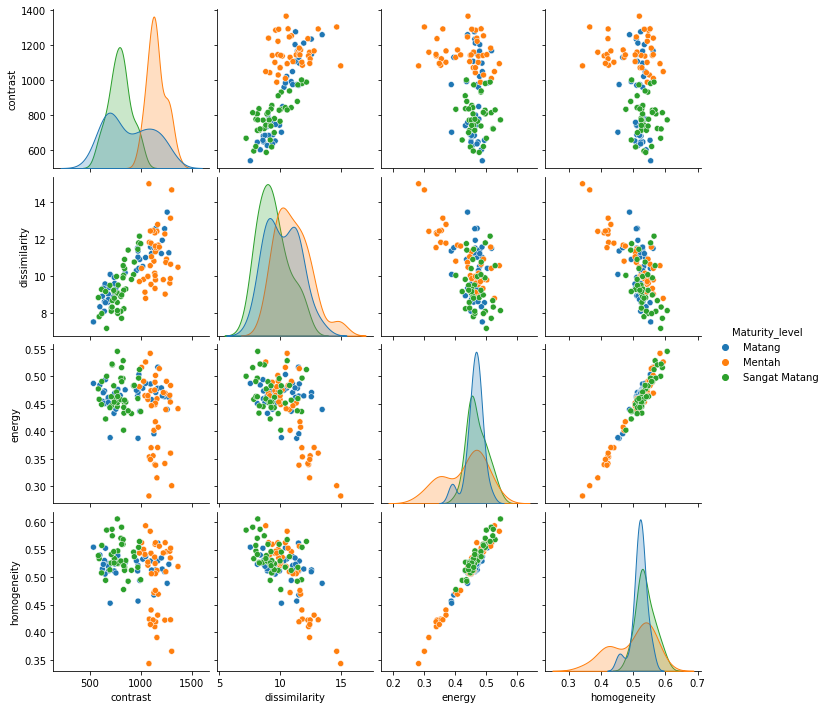

In [18]:
# Melihat persebaran data
import seaborn as sns
sns.pairplot(datamangga, hue = 'Maturity_level')

In [21]:
# Melakukan normalisasi pada data mangga
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(datamangga.drop('Maturity_level', axis=1))
# mangga_transform = scaler.transform(datamangga.drop('Maturity_level', axis=1))
# mangga_normal = pd.DataFrame(mangga_transform, columns=datamangga.columns[:-1])
# mangga_normal

scale_data_min_ = [300.0, 5.0, 0.0, 0.3]
scale_data_max_ = [1600.0, 20.0, 0.6, 0.8]
mangga_transform = pd.DataFrame(datamangga, columns=datamangga.columns[:-1])
idx = 0
for col in mangga_transform.columns:
    for row in range(mangga_transform[col].size):
        val = float(mangga_transform[col][row])
        val = (val - scale_data_min_[idx]) / (scale_data_max_[idx] - scale_data_min_[idx])
        mangga_transform[col][row] = val
    idx += 1
mangga_normal = pd.DataFrame(mangga_transform, columns=datamangga.columns[:-1])
mangga_normal


,contrast,dissimilarity,energy,homogeneity
0,0.652378,0.505771,0.784277,0.425986
1,0.421880,0.346665,0.792413,0.451932
2,0.531809,0.394149,0.727391,0.387936
3,0.518716,0.424353,0.645308,0.312893
4,0.719132,0.504384,0.771624,0.419216
...,...,...,...,...
115,0.323122,0.223015,0.870571,0.573382
116,0.517409,0.430597,0.765929,0.435325
117,0.490555,0.384648,0.805810,0.474046
118,0.539055,0.450912,0.726476,0.390365


In [22]:
# Membagi data uji dan data latih
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mangga_transform, datamangga['Maturity_level'], test_size = 0.2, random_state=7)
len(X_test)

24

In [24]:
# Melatih model menggunakan KNN
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')
model.fit(X_train, y_train)
prediksi = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediksi))

0.6666666666666666


In [25]:
import sklearn

print(sklearn.__version__)

0.22


[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
001
mangga - matang


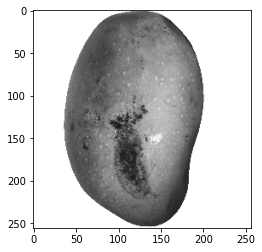

In [26]:
print(imgs[0])
plt.imshow(imgs[0], cmap='gray')
print(labels[0])
print(descs[0])

dataset
['Sangat Matang']


C:\Users\JinZhuXing\anaconda3\envs\tensor2\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


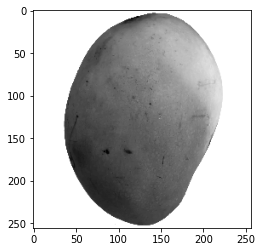

In [28]:
# test model

# load test image
print(dataset_dir)
test_img = cv2.imread(os.path.join(dataset_dir + '/mangga/sangat_matang/003.JPG'))
test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
test_resize = cv2.resize(test_gray, (256,256))
plt.imshow(test_resize, cmap='gray')

# process for predict
glcm_test_data = []
glcm_test_data.append(calc_glcm_all_agls(test_resize, 
    'matang',
    props=properties))
pre_datamangga = pd.DataFrame(glcm_test_data, 
                      columns = columns)
# print(pre_datamangga)

# minmax scale for predict
idx = 0
for col in pre_datamangga.columns[:-1]:
    for row in range(pre_datamangga[col].size):
        val = float(pre_datamangga[col][row])
        val = (val - scale_data_min_[idx]) / (scale_data_max_[idx] - scale_data_min_[idx])
        pre_datamangga[col][row] = val
    idx += 1
pre_normal = pd.DataFrame(pre_datamangga, columns=pre_datamangga.columns[:-1])
# print(pre_normal)

# predict
pre_result = model.predict(pre_normal)
print(pre_result)

In [29]:
from sklearn_porter import Porter

# export model
porter = Porter(model, language='java')
output = porter.export(export_data=True)
print(output)

import java.io.File;
import java.io.FileNotFoundException;
import java.util.*;
import com.google.gson.Gson;


class KNeighborsClassifier {

    private class Classifier {
        private int kNeighbors;
        private int nClasses;
        private double power;
        private double[][] X;
        private int[] y;
    }

    private class Sample {
        Integer y;
        Double dist;
        private Sample(int y, double distance) {
            this.y = y;
            this.dist = distance;
        }
    }

    private Classifier clf;
    private int nTemplates;

    public KNeighborsClassifier(String file) throws FileNotFoundException {
        String jsonStr = new Scanner(new File(file)).useDelimiter("\\Z").next();
        this.clf = new Gson().fromJson(jsonStr, Classifier.class);
        this.nTemplates = this.clf.y.length;
    }

    private static double compute(double[] temp, double[] cand, double q) {
        double dist = 0.;
        double diff;
        for (int i = 0, l = 

C:\Users\JinZhuXing\anaconda3\envs\tensor2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\JinZhuXing\anaconda3\envs\tensor2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.weight_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\JinZhuXing\anaconda3\envs\tensor2\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  

In [30]:
# Melihat True Positive dan False Negative
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,prediksi))

[[5 1 0]
 [1 7 0]
 [6 0 4]]


In [31]:
# Memilih nilai K
accuracy_rate = []

for k in range(1,50):  # maksmimal rangenya 96 (data train)
  model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
  yhat = model.predict(X_test)
  accuracy_rate.append(metrics.accuracy_score(y_test, yhat))

In [32]:
print("Akurasi maksimum:",max(accuracy_rate),"pada K =",(accuracy_rate.index(max(accuracy_rate))+1))

Akurasi maksimum: 0.75 pada K = 37


Text(0, 0.5, 'Accuracy Rate')

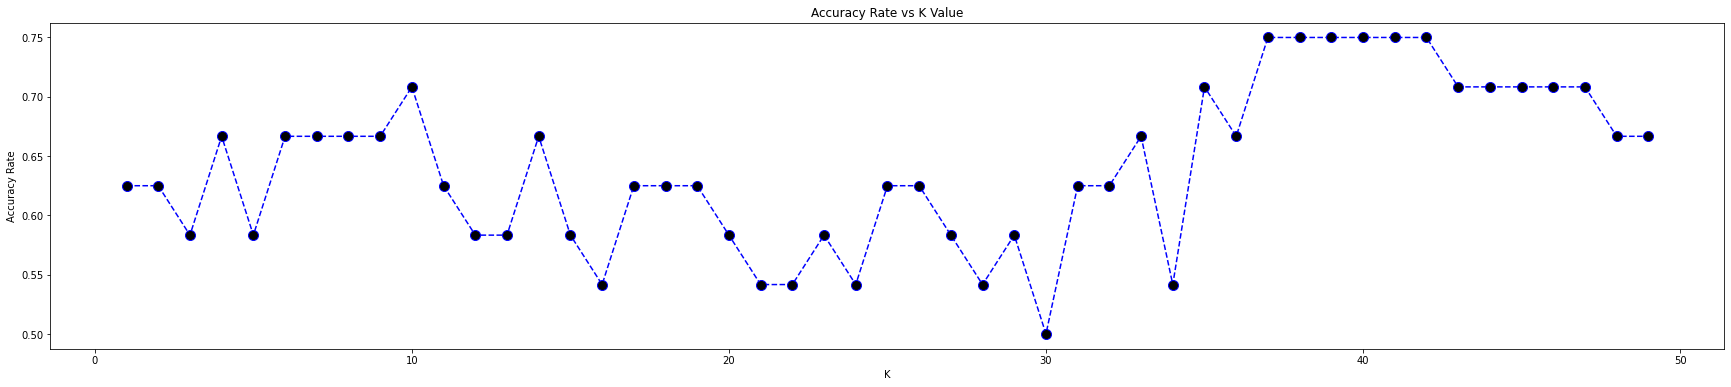

In [33]:
plt.figure(figsize=(30,6))
plt.plot(range(1,50), accuracy_rate, color = 'blue', linestyle = 'dashed', marker = 'o', markerfacecolor='black', markersize=10)
plt.title('Accuracy Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Accuracy Rate')

In [34]:
# Memasukkan K yang baru (optimal)
model = KNeighborsClassifier(n_neighbors=6)
model.fit(X_train, y_train)
prediksi = model.predict(X_test)
print(metrics.accuracy_score(y_test, prediksi))

0.6666666666666666


In [35]:
# Melihat True Positive dan False Negative yang baru
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,prediksi))

[[5 1 0]
 [1 7 0]
 [6 0 4]]


In [22]:
# Prediksi Model
print(model.predict([[0.1577, 0.441, 0.42, 0.52, 0.99, 0.656, 0,7421, 0,762, 0,2122, 0,8523, 0,9898, 0,8891, 0,4444, 0,2211, 0,11234, 0,6542]]))

ValueError: X has 26 features, but KNeighborsClassifier is expecting 16 features as input.